# EGB_MLP网络可视化

**目标：**


1.   学习神经网络在训练过程中，隐含层的特征变化机制
2.   学习端到端梯度提升算法(End to end gradient boosting, EGB)

代码中的基学习器为多层感知机(multi layer perception, mlp)


**参考：**

葛家驿,杨乃森,唐宏,徐朋磊,纪超.端到端的梯度提升网络分类过程可视化[J].信号处理,2022,38(02):355-366.DOI:10.16798/j.issn.1003-0530.2022.02.015.



## 研究准备

### **环境配置**

In [ ]:
'''
端到端梯度提升模型分类过程可视化
每个基分类器是全连接网络
'''

import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles #同心圆数据
from sklearn.model_selection import train_test_split
import sys
sys.setrecursionlimit(500000)
import imageio
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


### **设置模拟数据**

In [ ]:
n_samples = 1000 #样本点数
X, y = make_circles(n_samples=1000,factor=.4,noise=.06,random_state=0) #生成同心圆数据
test_size = 0.5

#划分训练集、测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=2)

c,r = np.mgrid[[slice(X.min()- .2,X.max() + .2,50j)]*2]
p = np.c_[c.flat,r.flat]

ss = StandardScaler().fit(X_train)
X = ss.transform(X)
p = ss.transform(p)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

### **配置绘图环境**

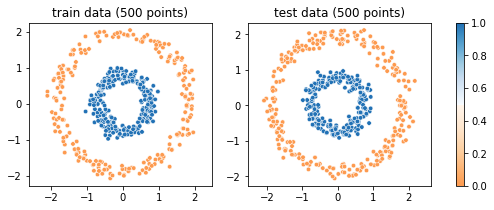

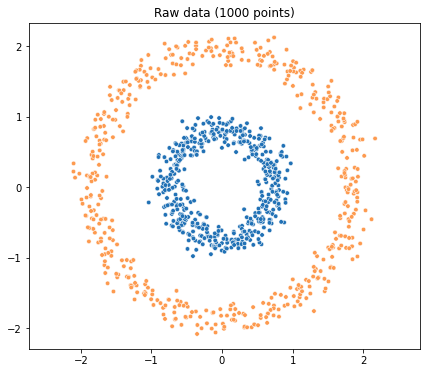

In [ ]:
#设置画布大小和颜色
fig = plt.figure(figsize = (9,3))
top = cm.get_cmap('Oranges_r', 512)
bottom = cm.get_cmap('Blues', 512)
newcolors = np.vstack((top(np.linspace(0.55, 1, 512)),
                       bottom(np.linspace(0, 0.75, 512))))
cm_bright = ListedColormap(newcolors, name='OrangeBlue')

#训练数据可视化
plt.subplot(121)
m1 = plt.scatter(*X_train.T,c = Y_train,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
plt.title(f'train data ({int(n_samples*(1-test_size))} points)')
plt.axis('equal')

#测试数据可视化
plt.subplot(122)
m2 = plt.scatter(*X_test.T,c = Y_test,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5);
plt.title(f'test data ({int(n_samples*test_size)} points)')
plt.axis('equal')
ax = fig.get_axes()
plt.colorbar(ax = ax)
#plt.savefig(f'data_{n_samples}_points.png')
#plt.savefig(f'data_{n_samples}_points.pdf')
plt.show()

#全部数据可视化
fig = plt.figure(figsize = (7,6))
plt.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
plt.title(f'Raw data ({n_samples} points)')
plt.axis('equal')
#plt.savefig(f'Raw data ({n_samples} points)')
#plt.savefig(f'Raw data ({n_samples} points).pdf')
plt.axis('equal')
plt.show()

### **配置数据与损失函数**

In [ ]:
num_classes=2 #设置类别数
y_train=keras.utils.to_categorical(Y_train,num_classes) #类别标签转换为onehot编码
y_test=keras.utils.to_categorical(Y_test,num_classes)
#定义损失曲线绘制函数

def plot_loss_accuracy(history, title_text, file_name):

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Loss")
    
    #ax1.set_ylim(-0.01,1.01)
    ax1.plot(history.epoch,
             history.history['accuracy'],
             label="Training Accuracy")
    ax1.plot(history.epoch,
             history.history['val_accuracy'],
             linestyle='--',
             label="Test Accuracy")
    
    #ax2.set_ylim(-0.01,1.01)
    ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler 
    
    ax2.plot(history.epoch, 
             history.history['loss'], 
             label="Training Loss")
    ax2.plot(history.epoch,
             history.history['val_loss'],
             linestyle='--',
             label="Test Loss")

    ax1.legend()
    ax2.legend()
    plt.suptitle(title_text)
    plt.savefig(file_name)

### **构建基于全连接网络的端到端梯度提升模型**

In [ ]:
#定义全连接网络

def FullyConnected_Block(name_of_classifiers,
                         number_of_layers,
                         num_neurons_of_layer,
                         inputs):
    x = inputs
    for n in range(number_of_layers):
        inputs = x
        x = layers.Dense(num_neurons_of_layer,
                         activation=tf.nn.relu,
                         name = f'{name_of_classifiers}th-clf_{n}th-hidden')(x)
    return x
#构建全连接基分类器

def build_fully_connected_model(name_of_classifiers,
                                number_of_layers,
                                num_neurons_of_layer,
                                inputs):
    x = FullyConnected_Block(name_of_classifiers,
                             number_of_layers,
                             num_neurons_of_layer,
                             inputs)
    outputs = x
    #outputs = layers.Dense(num_classes,name=f'{name_of_classifiers}th-clf_logits')(x)
    fully_connected_model = keras.Model(inputs, outputs)
    return fully_connected_model
#构建EGB网络

def build_boosting_model(classifiers,
                         name_of_classifiers,
                         number_of_layers,
                         num_neurons_of_layer,
                         inputs):
    model_logits = build_fully_connected_model(name_of_classifiers,
                                               number_of_layers,
                                               num_neurons_of_layer,
                                               inputs)
    classifiers.append(model_logits)
    #如果有多个分类器，每个分类器最后一层的输出相加，然后softmax
    if len(classifiers)>1:
        fully_boost_model = layers.Add(name='classifiers_Add')([item.outputs[0] for item in classifiers])
    else:
        fully_boost_model = model_logits.outputs[0]
    outputs = layers.Dense(2, activation='softmax',name = 'activation')(fully_boost_model)
    boosting_model = keras.Model(inputs, outputs)
    return boosting_model,model_logits

### **定义模型训练方式**

In [ ]:
#定义模型训练

def train_FullyBoost_model(number_of_weak_classifiers,
                           number_of_layers,
                           num_neurons_of_layer,
                           batch_size,
                           epochs):
    
    classifiers = []
    history = []
    boosting_models = []
    
    inputs = keras.Input(shape=(2, ))
    
    #每次叠加一个基分类器拟合训练数据
    for n_th_weak in range(number_of_weak_classifiers):
        name_of_classifiers = n_th_weak
        boosting_model,model_logits=build_boosting_model(classifiers,
                                                         name_of_classifiers,
                                                         number_of_layers,
                                                         num_neurons_of_layer,
                                                         inputs)

        boosting_model.compile(loss=keras.losses.categorical_crossentropy,
                                  optimizer=keras.optimizers.Adam(lr=3e-4),
                                  metrics=['accuracy'])
        #csv_logger = CSVLogger(f'training_{name_of_classifiers}.log') #保存训练日志
        new_history = boosting_model.fit(X_train,
                                         y_train,
                                         batch_size=batch_size,
                                         epochs=epochs,
                                         verbose=2,
                                         #callbacks=[csv_logger],
                                         validation_data=(X_test, y_test))
        
        #在训练新的基分类器时，所有前面的基分类器每层的参数冻结
        for layer in classifiers[-1].layers:
            layer.trainable = False
        history.append(new_history)
        boosting_models.append(boosting_model)
        #model_logits.save_weights(f"single_classifier_{name_of_classifiers}.h5") #保存基分类器
        print('第{}个弱分类器训练完毕'.format(n_th_weak+1))
        
    #boosting_model.save(f'boosting_model_with_{number_of_weak_classifiers}_classifiers.h5') #保存模型
    return boosting_model,boosting_models,history

## 进行实验

### **设置训练参数**

In [ ]:
#设置参数

epochs=100 #迭代次数
batch_size=32 #batchsize
number_of_weak_classifiers=5 #基分类器个数
number_of_layers=4 #基分类器的隐层数
num_neurons_of_layer=2 #隐层的神经元数

#训练模型
boosting_model,boosting_models,history=train_FullyBoost_model(number_of_weak_classifiers,
                                                              number_of_layers,
                                                              num_neurons_of_layer,
                                                              batch_size,
                                                              epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
16/16 - 2s - loss: 1.0253 - accuracy: 0.5240 - val_loss: 1.1483 - val_accuracy: 0.4640 - 2s/epoch - 148ms/step
Epoch 2/100
16/16 - 0s - loss: 1.0180 - accuracy: 0.5140 - val_loss: 1.1382 - val_accuracy: 0.4640 - 273ms/epoch - 17ms/step
Epoch 3/100
16/16 - 0s - loss: 1.0109 - accuracy: 0.4980 - val_loss: 1.1285 - val_accuracy: 0.4400 - 165ms/epoch - 10ms/step
Epoch 4/100
16/16 - 0s - loss: 1.0039 - accuracy: 0.4620 - val_loss: 1.1193 - val_accuracy: 0.4200 - 260ms/epoch - 16ms/step
Epoch 5/100
16/16 - 0s - loss: 0.9971 - accuracy: 0.4380 - val_loss: 1.1103 - val_accuracy: 0.3820 - 157ms/epoch - 10ms/step
Epoch 6/100
16/16 - 0s - loss: 0.9908 - accuracy: 0.3760 - val_loss: 1.1015 - val_accuracy: 0.3160 - 289ms/epoch - 18ms/step
Epoch 7/100
16/16 - 0s - loss: 0.9846 - accuracy: 0.3540 - val_loss: 1.0926 - val_accuracy: 0.3320 - 188ms/epoch - 12ms/step
Epoch 8/100
16/16 - 0s - loss: 0.9780 - accuracy: 0.4020 - val_loss: 1.0848 - val_accuracy: 0.3820 - 132ms/epoch - 8ms/step
Epo

### **可视化结果**

#### **绘制训练曲线**

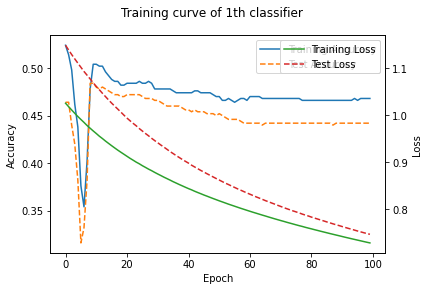

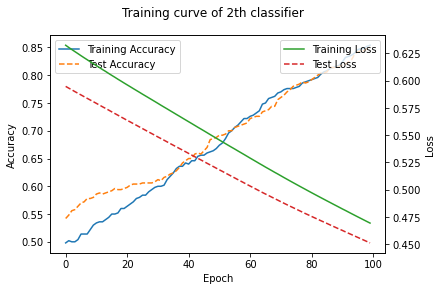

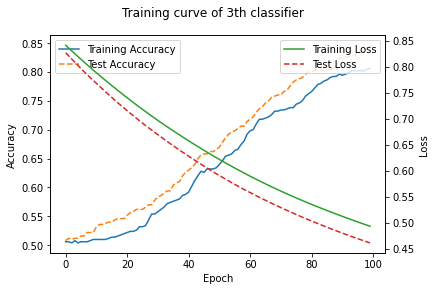

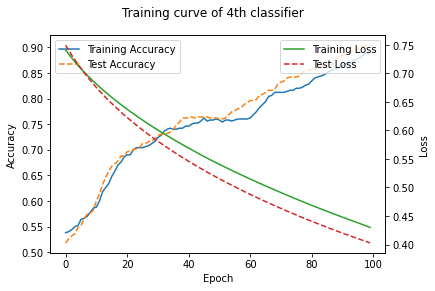

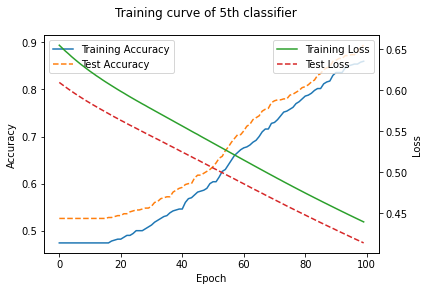

In [ ]:
#绘制每个基分类器的训练曲线
for i in range(number_of_weak_classifiers):
    plot_loss_accuracy(history[i],
                       f'Training curve of {i+1}th classifier',
                       f'Training curve of {i+1}th classifier')

#### **输出模型结构信息**

In [ ]:
#打印模型结构和参数信息
print(boosting_model.summary())

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 0th-clf_0th-hidden (Dense)     (None, 2)            6           ['input_1[0][0]']                
                                                                                                  
 1th-clf_0th-hidden (Dense)     (None, 2)            6           ['input_1[0][0]']                
                                                                                                  
 2th-clf_0th-hidden (Dense)     (None, 2)            6           ['input_1[0][0]']                
                                                                                            

#### **对原始特征空间剖分的可视化**

79/79 [==============================] - 0s 1ms/step


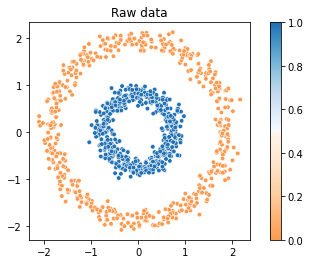

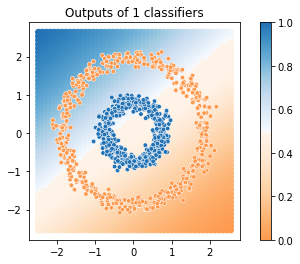

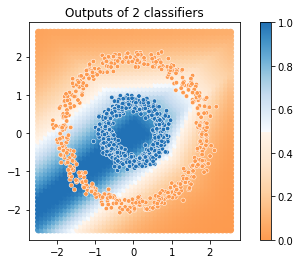

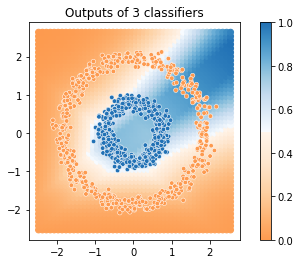

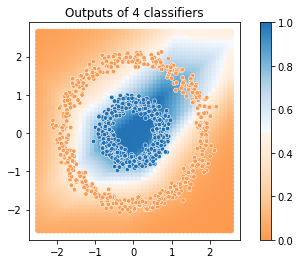

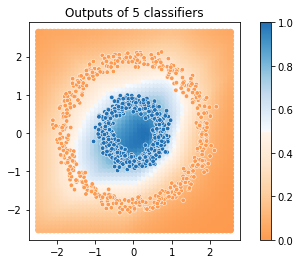

In [ ]:
#对原始特征空间剖分的可视化

#可视化原始特征空间
fig, ax1= plt.subplots(1,1, figsize=(7, 4),subplot_kw = {'aspect':'equal'})
mp = ax1.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
plt.colorbar(mp,ax = [ax1]);
plt.title(f'Raw data')
plt.savefig(f'Raw data.png')
plt.savefig(f'Raw data.pdf')

#可视化每叠加一个基分类器后的EGB模型对原始特征空间的剖分
for i in range(number_of_weak_classifiers):
    prob = boosting_models[i].predict(p)[:,1]
    fig, ax1= plt.subplots(1,1, figsize=(7, 4),subplot_kw = {'aspect':'equal'})
    ax1.scatter(*p.T,c = prob,cmap = cm_bright)
    mp = ax1.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
    plt.colorbar(mp,ax = [ax1]);
    plt.title(f'Outputs of {i+1} classifiers')
    plt.savefig(f'Space division of {i+1} classifiers.png')
    plt.savefig(f'Space division of {i+1} classifiers.pdf')
    
#生成动图
def create_gif(image_list, gif_name, duration=1):
    frames = []
    for image_name in image_list:
        frames.append(imageio.imread(image_name))
    imageio.mimsave(gif_name, frames, 'GIF', duration=duration)
    return

def main():
    image_list = ['Raw data.png']
    for i in range(number_of_weak_classifiers):
        image_list.append(f'Space division of {i+1} classifiers.png')
    gif_name = '空间剖分动图.gif'
    duration = 0.8
    create_gif(image_list, gif_name, duration)

main()

#### **更换背景显示原始样本**

<Figure size 648x216 with 0 Axes>

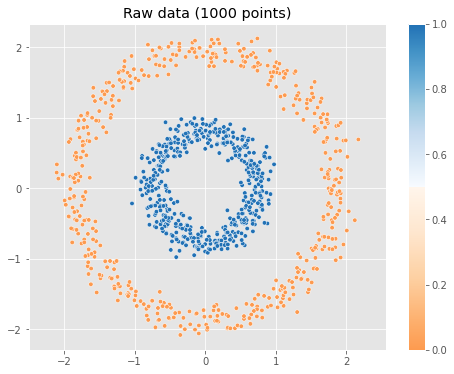

In [ ]:
#更换背景显示原始样本

mpl.style.use('ggplot')

fig = plt.figure(figsize = (9,3))
top = cm.get_cmap('Oranges_r', 512)
bottom = cm.get_cmap('Blues', 512)
newcolors = np.vstack((top(np.linspace(0.55, 1, 512)),
                       bottom(np.linspace(0, 0.75, 512))))
cm_bright = ListedColormap(newcolors, name='OrangeBlue')

fig = plt.figure(figsize = (8,6))
m3 = plt.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
plt.title(f'Raw data ({n_samples} points)')
plt.axis('equal')
plt.colorbar()
plt.savefig(f'Raw data ({n_samples} points)')
plt.savefig(f'Raw data ({n_samples} points).pdf')
plt.axis('equal')
#plt.colorbar(ax = ax)
plt.show()

#### **特征变换过程可视化**

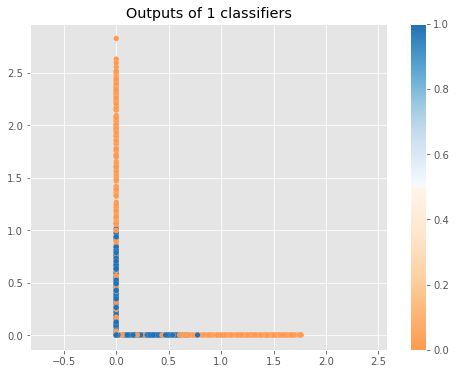

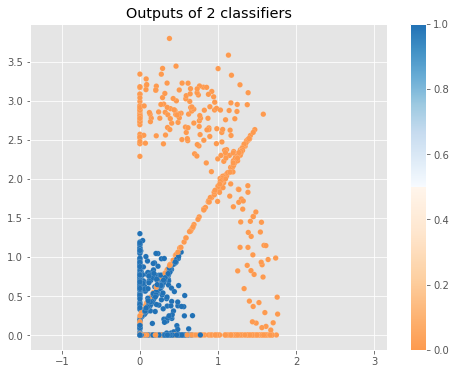

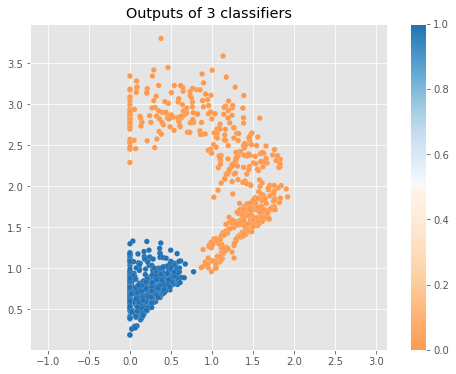

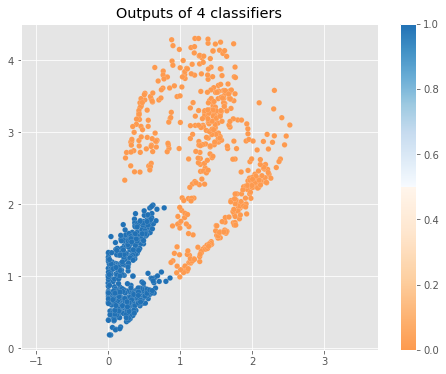

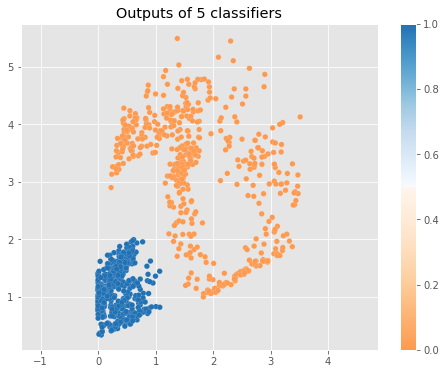

In [ ]:
#对样本点特征变换的可视化

clf_add_layers = []
clf_add_layers.append(boosting_models[0].get_layer('0th-clf_0th-hidden'))
for i in range(len(boosting_models)-1):
    add_layer = boosting_models[i+1].get_layer('classifiers_Add')
    clf_add_layers.append(add_layer)

inp = boosting_model.input
outputs = [layer.output for layer in clf_add_layers]
functors = [K.function([inp], [out]) for out in outputs]
boosting_model_outs = [func([X]) for func in functors]

#可视化每叠加一个基分类器后的EGB模型对样本点特征变换后的状态
for idx in range(len(boosting_model_outs)):
    fig = plt.figure(figsize = (8,6))
    scatter(boosting_model_outs[idx][0][:,0],boosting_model_outs[idx][0][:,1],
            c = y,cmap = cm_bright,edgecolors='white',s = 30,linewidths = 0.1)
    plt.axis('equal')
    plt.title(f'Outputs of {idx+1} classifiers')
    plt.colorbar()
    plt.savefig(f'Outputs of {idx+1} classifiers.png')
    plt.savefig(f'Outputs of {idx+1} classifiers.pdf')
    plt.show()
    
#生成动图
def create_gif(image_list, gif_name, duration=1):
    frames = []
    for image_name in image_list:
        frames.append(imageio.imread(image_name))
    imageio.mimsave(gif_name, frames, 'GIF', duration=duration)
    return

def main():
    image_list = [f'Raw data ({n_samples} points).png']
    for i in range(len(boosting_model_outs)):
        image_list.append(f'Outputs of {i+1} classifiers.png')
    gif_name = '特征变换动图.gif'
    duration = 0.8
    create_gif(image_list, gif_name, duration)

main()